In [71]:
import sys
sys.path.append('../../../../PhD_projects/utils/')
from cmptTheoreticalEmitGrowth import *
from bunchLengthConversions import *
from coordinatesConversions import *
from cmpt_TuneSpreads import *

import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [260]:
params = {'legend.fontsize': 23,
          'figure.figsize': (9.5, 8.5),
          'axes.labelsize': 30,
          'axes.titlesize': 30,
          'xtick.labelsize': 30,
          'ytick.labelsize': 30,
          'image.cmap': 'jet',
          'lines.linewidth': 3,
          'lines.markersize': 12,
          'font.family': 'sans-serif'}

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

In [261]:
n_sets = 10
n_runs = 3 # number of runs that the simulation was repeated
n_turns = int(1e5)            # number of cycles to run the simulation for
decTurns = int(100)           # how often to record data
circumference  = 6911.5623 # [m]
f_rev  = 299792458/circumference  # [Hz] The revolution frequency of the machine 
separationTime = 1 / f_rev * decTurns #There are decTurns revolutions before each recording of data
tspan = (np.arange(n_turns / decTurns) + 1.0) * separationTime #total time spanned by the simulation

In [262]:
### Compute theoretical model
# Machine parameters
betay = 73.81671646 # 73 m at CC2, 76 m at CC1
Vcc = 1e6 # V
Eb = 270e9 # eV
gamma_0 = 287.8 
beta_0 = np.sqrt(1 - 1/gamma_0**2)
circumference = 6911.5623 # m
frev = 299792458/circumference # Hz
sigma_z = 0.155 # m
f_CC = 400.789e6 # CC frequency in Hz
clight = 299792458 # m/s
# Noise kick parameters
A_phase = 1e-8 # rms kick in the simulation of the phase noise
A_amplitude = 0 # rms kick in the simulation of the amplitude noise
scale_factor = Eb/Vcc # scaling factor to rms noise, σ
# Compute the PSD in rad^2/Hz and V^2/Hz
#PSD_phi = (A_phase * scale_factor)**2/frev # rad^2/Hz
#PSD_A = (A_amplitude * scale_factor)**2/frev # V^2/Hz
PSD_phi = 7.22e-11 #6.9e-11
PSD_Α = 3.04e-12 #3.10e-12
print(f'psd phi: {PSD_phi} rad^2/Hz, psd A: {PSD_A} V^2/Hz')

psd phi: 7.22e-11 rad^2/Hz, psd A: 3.04e-12 V^2/Hz


In [263]:
# Compute the correction factor due to the bunch length
sigma_phi = bunch_length_m_to_rad(sigma_z, clight, f_CC)
CDeltaphi = cmpt_bunch_length_correction_factor(sigma_phi, 'PN')
CDeltaA = cmpt_bunch_length_correction_factor(sigma_phi, 'AN')
print('CDeltaPhi = {}, CDeltaA = {}'.format(CDeltaphi, CDeltaA))

if noise_type == 'PN':
    expected_growth = emit_growth_phase_noise(betay, Vcc, frev, Eb, CDeltaphi, PSD_phi, one_sided_psd=False)*beta_0*gamma_0 # m/s
elif noise_type == 'AN':
    expected_growth = emit_growth_amplitude_noise(betay, Vcc, frev, Eb, CDeltaA, PSD_A, one_sided_psd=False)*beta_0*gamma_0 # m/s
else:
    expected_growth_1 = emit_growth_phase_noise(betay, Vcc, frev, Eb, CDeltaphi, PSD_phi, one_sided_psd=False)*beta_0*gamma_0 # m/s
    expected_growth_2 = emit_growth_amplitude_noise(betay, Vcc, frev, Eb, CDeltaA, PSD_A, one_sided_psd=False)*beta_0*gamma_0 # m/s
    expected_growth = expected_growth_1 + expected_growth_2

print('expected growth = {} nm/s'.format(expected_growth*1e9))

CDeltaPhi = 0.5168486015622045, CDeltaA = 0.24157569921889774
expected growth = 10.63263500351641 nm/s


In [264]:
expected_growth_list = [expected_growth_1, expected_growth_2, expected_growth]

In [265]:
path_to_data = './'

noise_types = ['PN', 'AN', 'AN_PN'] # 'AN','PN', 'BOTH'

study_name = f'eyEvolution_sps_270GeV_WakesOFF_ayy1500_QpxQpy1_Nb5e5_IPACvalues_coast1_setting2'


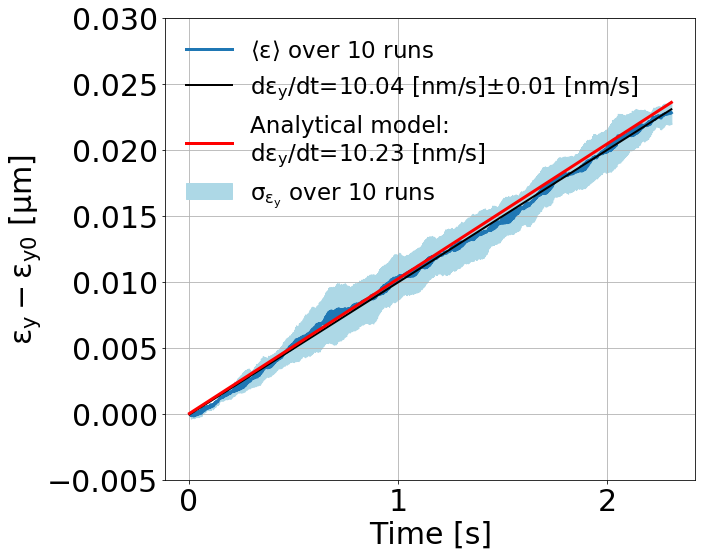

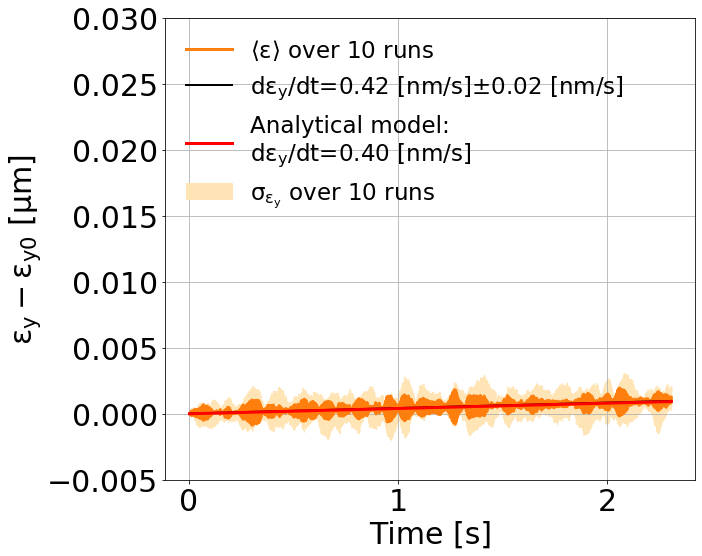

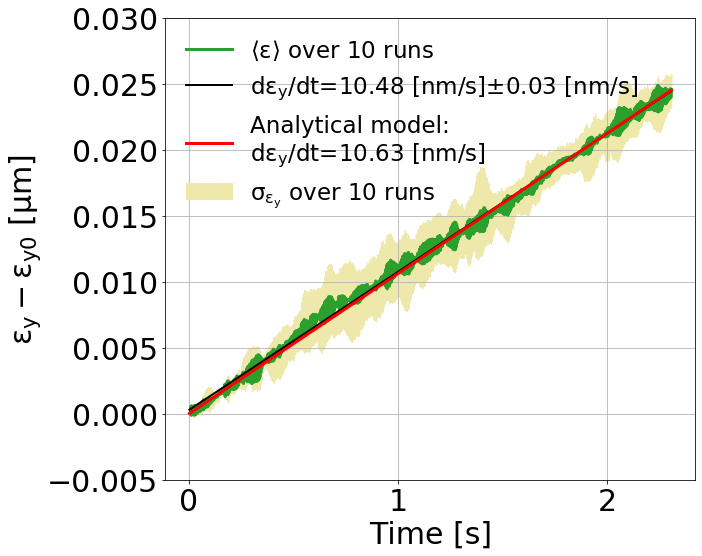

In [271]:
#fig, ax = plt.subplots(1, 1)

fill_between_colors = ['lightblue', 'moccasin', 'palegoldenrod']
colors = ['C0', 'C1', 'C2']

for i, noise_type in enumerate(noise_types):
    fig, ax = plt.subplots(1, 1)
    df = pickle.load(open(f'{study_name}_{noise_type}_MD5_parameters.pkl','rb'))
    
    initial_ey= df['ey mean'][0][2]
    initial_std = df['ey std'][0][2]
    
    ax.plot(tspan[2:], (df['ey mean'][0][2:]-initial_ey)*1e6, c=colors[i], label=r'$\mathrm{\langle \epsilon \rangle}$'+f' over {n_sets} runs')
    ax.fill_between(tspan[2:], (df['ey mean'][0][2:]-initial_ey)*1e6-(df['ey std'][0][2:]-initial_std)*1e6, (df['ey mean'][0][2:]-initial_ey)*1e6+(df['ey std'][0][2:]-initial_std)*1e6, color=fill_between_colors[i], label=r'$\mathrm{\sigma_{\epsilon_y}}$'+f' over {n_sets} runs')
    
    
    # polynomial fit, first degree
    [m, b], cov = np.polyfit(tspan[2:], df['ey mean'][0][2:], 1, cov=True)
    err= np.sqrt(np.diag(cov))
            
    
    ax.plot(tspan, 1e6*(m*tspan+b-initial_ey), c='k', lw=2, label=r'$\mathrm{d\epsilon_y/dt}$'+f'={m*1e9:.2f} [nm/s]'+r'$\pm$'+f'{err[0]*1e9:.2f} [nm/s]')
    
    # plot growth rate as estimated from the analytical model
    ax.plot(tspan, expected_growth_list[i]*tspan*1e6, c='r', lw=3, label='Analytical model:\n'+r'$\mathrm{d\epsilon_y/dt}$'+f'={expected_growth_list[i]*1e9:.2f} [nm/s]')
    
    
    
    ax.set_ylim(-0.005, 0.03)
    ax.set_ylabel(r'$\mathrm{\epsilon_y - \epsilon_{y0} \ [\mu m]}$')
    ax.set_xlabel('Time [s]')
    ax.grid()
    ax.legend(loc=2, frameon=False)
    #plt.tight_layout()
    
    plt.savefig(f'./figures/emitGrowth_{study_name}_{noise_type}.png', bbox_inches='tight')

In [164]:
my_df_keys = list(my_df_1.keys()) 
print(my_df_keys)

['ayy_1500 [1/m]']


In [165]:
summary_dict_1 = {} # dictionary to save the average emittance growth rate and the error

for i, key in enumerate(my_df_keys):
    summary_dict_1[f'{key}'] = [] 
    
    # errors for study 1
    systematic_error_1 = np.std(my_df_1[my_df_keys[i]]['m'])
    statistical_error_1 = np.sqrt(np.mean(np.array(my_df_1[my_df_keys[i]]['err'])**2))
    total_error_1 = np.sqrt(systematic_error_1**2+statistical_error_1**2)  
    
     
    # average growth rates
    summary_dict_1[f'{key}'].append(np.mean(my_df_1[my_df_keys[i]]['m'])) # m/s
     
    # totoal errors
    summary_dict_1[f'{key}'].append(total_error_1) # m/s

In [70]:
summary_dict_1

{'ayy_1500 [1/m]': [1.0481284972827904e-08, 1.1529556697112923e-09]}

In [63]:
# Machine parameters
betay = 73.81671646 # 73 m at CC2, 76 m at CC1
Vcc = 1e6 # V
Eb = 270e9 # eV
gamma_0 = 287.8 
beta_0 = np.sqrt(1 - 1/gamma_0**2)
circumference = 6911.5623 # m
frev = 299792458/circumference # Hz
sigma_t = 1.7e-9/4  # initial bunch 1, coast2-setting2
sigma_z = bunch_length_time_to_m(sigma_t, clight)
print(sigma_z)
#sigma_z = 0.155 # m
f_CC = 400.789e6 # CC frequency in Hz
clight = 299792458 # m/s
# Noise kick parameters
A_phase = 1e-8 # rms kick in the simulation of the phase noise
A_amplitude = 0 # rms kick in the simulation of the amplitude noise
scale_factor = Eb/Vcc # scaling factor to rms noise, σ
# Compute the PSD in rad^2/Hz and V^2/Hz
PSD_phi = (A_phase * scale_factor)**2/frev # rad^2/Hz
PSD_phi = 7.22e-11
#PSD_phi = 1.4e-10
PSD_A = (A_amplitude * scale_factor)**2/frev # V^2/Hz
PSD_A = 3.04e-12
print(f'psd phi: {PSD_phi} rad^2/Hz, psd A: {PSD_A} V^2/Hz')

0.12741179465
psd phi: 7.22e-11 rad^2/Hz, psd A: 3.04e-12 V^2/Hz


In [65]:
# Compute the correction factor due to the bunch length
noise_type='PN'
sigma_phi = bunch_length_m_to_rad(sigma_z, clight, f_CC)
CDeltaphi = cmpt_bunch_length_correction_factor(sigma_phi, 'PN')
CDeltaA = cmpt_bunch_length_correction_factor(sigma_phi, 'AN')
print('CDeltaPhi = {}, CDeltaA = {}'.format(CDeltaphi, CDeltaA))

if noise_type == 'PN':
    expected_growth = emit_growth_phase_noise(betay, Vcc, frev, Eb, CDeltaphi, PSD_phi, one_sided_psd=False)*beta_0*gamma_0 # m/s
    my_color = 'C0'
    fill_bewtween_color = 'lightblue'
elif noise_type == 'AN':
    expected_growth = emit_growth_amplitude_noise(betay, Vcc, frev, Eb, CDeltaA, PSD_A, one_sided_psd=False)*beta_0*gamma_0 # m/s
    my_color = 'C1'
    fill_bewtween_color = 'moccasin'
else:
    my_color = 'C2'
    expected_growth_1 = emit_growth_phase_noise(betay, Vcc, frev, Eb, CDeltaphi, PSD_phi, one_sided_psd=False)*beta_0*gamma_0 # m/s
    expected_growth_2 = emit_growth_amplitude_noise(betay, Vcc, frev, Eb, CDeltaA, PSD_A, one_sided_psd=False)*beta_0*gamma_0 # m/s
    expected_growth = expected_growth_1 + expected_growth_2

print('expected growth = {} nm/s'.format(expected_growth*1e9))

CDeltaPhi = 0.550589536911069, CDeltaA = 0.22470523154446553
expected growth = 10.897815980959816 nm/s
